# APPLICATION OF MACHINE LEARNING IN BIOLOGICAL SYSTEMS (ES60011) PROJECT 5

### 22CS30027
### Golla Meghanandh Manvith Prabhash

#### To classify unlabelled tumor images as Benign or Malignant.

## 1. Importing Libraries

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2024-11-07 18:43:05.976427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 18:43:05.987332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 18:43:06.078909: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 18:43:06.168055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730985186.253936   21688 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730985186.27

# 2. Preprocessing The Images:

### 2.1 Agumentation of the Data

In [2]:
def augument_image(image_path, save_to_dir):
    try:
        image = load_img(image_path)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return
    x = img_to_array(image)  
    x = np.expand_dims(x, axis=0) 

    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i > 5:
            break

In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [29]:
benign_dir = './Dataset2/Dataset2/FNA/benign/'
malignant_dir = './Dataset2/Dataset2/FNA/malignant/'

In [30]:
for dirname in [benign_dir, malignant_dir]:
    for filename in os.listdir(dirname):
        if filename.startswith("aug"): 
            file_path = os.path.join(dirname, filename)
            os.remove(file_path)

In [6]:
for dirname in [benign_dir, malignant_dir]:
    for filename in os.listdir(dirname):
        augument_image(os.path.join(dirname, filename), dirname)

### 2.2 Enhanceing Image

In [31]:
def enhance_image(image_path):
    image = cv2.imread(image_path)
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)
    adjusted = cv2.convertScaleAbs(sharpened, alpha=1.2, beta=50)
    cv2.imwrite(image_path, adjusted)

In [32]:
for dirname in [benign_dir, malignant_dir]:
    for filename in os.listdir(dirname):
        enhance_image(os.path.join(dirname, filename))

## 3. Training the CNN

### 3.1 Load Images

In [33]:
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img = load_img(os.path.join(folder, filename), target_size=(128, 128))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

In [34]:
benign_images, benign_labels = load_images('./Dataset2/Dataset2/FNA/benign', 0)
malignant_images, malignant_labels = load_images('./Dataset2/Dataset2/FNA/malignant', 1)

In [35]:
X = (np.array(benign_images + malignant_images))
X = X/255.0
y = np.array(benign_labels + malignant_labels)

In [36]:
y = to_categorical(y, num_classes=2)

In [37]:
y.shape

(1724, 2)

In [38]:
X.shape

(1724, 128, 128, 3)

### 3.2 Create CNN

In [39]:
def create_cnn_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### 3.3 K-Fold Cross Validation

In [40]:
def k_fold_cross_validation(X, y, k=5):
    X, y = shuffle_data(X, y)
    fold_size = len(X) // k
    histories = []
    last_model = None

    for fold in range(k):
        print(f'Training fold {fold + 1}...')
        start = fold * fold_size
        end = (fold + 1) * fold_size if fold != k - 1 else len(X)

        X_val, y_val = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]], axis=0)
        y_train = np.concatenate([y[:start], y[end:]], axis=0)

        model = create_cnn_model()
        history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
        histories.append(history.history)
        
        last_model = model
        
    return histories, last_model

### 3.4 Shuffle Function

In [41]:
def shuffle_data(X, y):
    permutation = np.random.permutation(len(X))
    return X[permutation], y[permutation]

### 3.5 Model Creation And Plotting Graphs

In [42]:
histories, last_model = k_fold_cross_validation(X, y, k=4)

Training fold 1...
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6838 - loss: 0.6394 - val_accuracy: 0.7680 - val_loss: 0.5199
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7637 - loss: 0.5127 - val_accuracy: 0.7355 - val_loss: 0.5547
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7569 - loss: 0.5260 - val_accuracy: 0.7726 - val_loss: 0.4894
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7842 - loss: 0.5053 - val_accuracy: 0.7401 - val_loss: 0.5760
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7960 - loss: 0.4724 - val_accuracy: 0.7703 - val_loss: 0.5119
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8271 - loss: 0.4141 - val_accuracy: 0.7889 - val_loss: 0.4565
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8175 - loss: 0.3995 - val_accuracy: 0.7981 - val_loss: 0.4426
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8248 - loss: 0.4018 - val_a

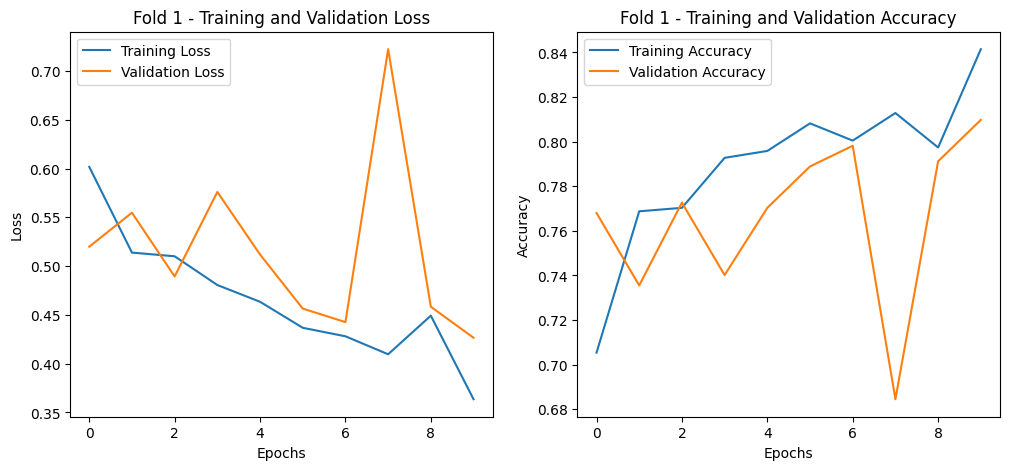

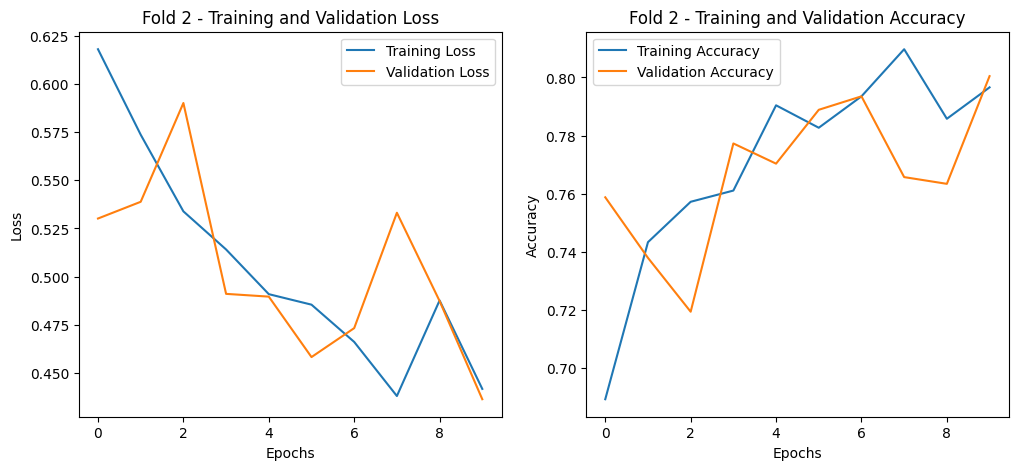

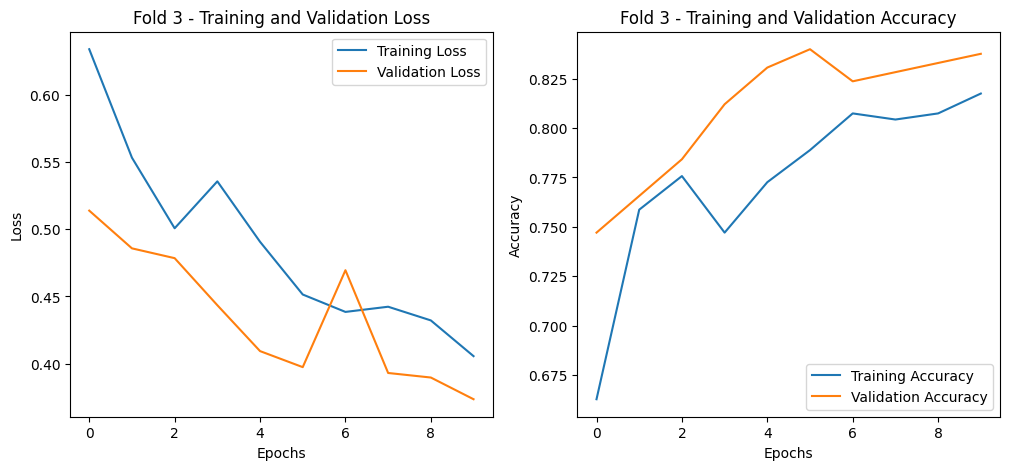

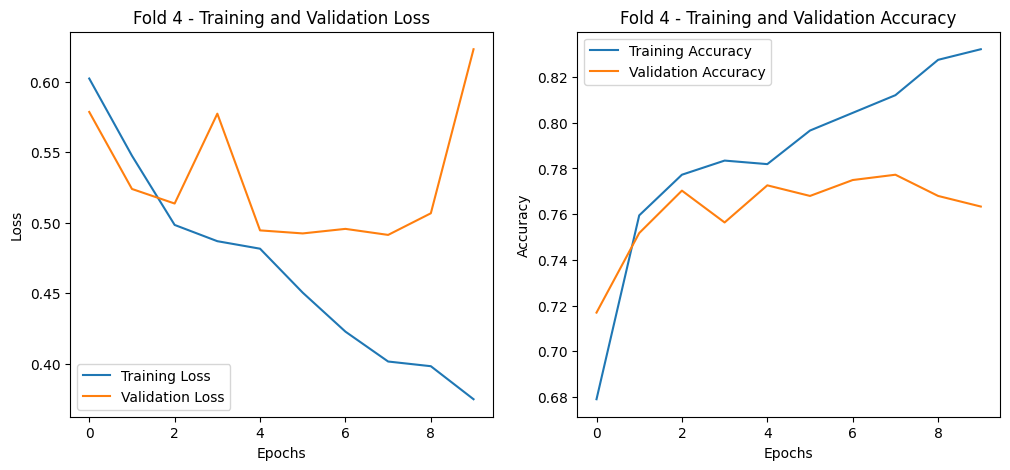

In [43]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

## 4.  Prediction

### 4.1 Load Images

In [44]:
def load_test_images(folder):
    images = []
    image_names = []
    for filename in os.listdir(folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            enhance_image(os.path.join(folder, filename))
            img = load_img(os.path.join(folder, filename), target_size=(128, 128))
            img_array = img_to_array(img)
            images.append(img_array)
            image_names.append(filename)
    return np.array(images), image_names

In [45]:
test_folder = './Dataset2/Dataset2/test'
X_test, test_image_names = load_test_images(test_folder)
X_test = X_test / 255.0

### 4.2 Predicting 

In [46]:
predictions = last_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # converting one-hot to class labels

print(predicted_classes)

# mapping predictions to labels
predicted_labels = ['Benign' if label == 0 else 'Malignant' for label in predicted_classes]

for image_name, label in zip(test_image_names, predicted_labels):
    print(f'Image: {image_name}, Prediction: {label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[1 0 1 0 0 1 1 0 0 0 0 0 0 0]
Image: thirteen.png, Prediction: Malignant
Image: five.png, Prediction: Benign
Image: eight.png, Prediction: Malignant
Image: one.png, Prediction: Benign
Image: ten.png, Prediction: Benign
Image: fourteen.png, Prediction: Malignant
Image: eleven.png, Prediction: Malignant
Image: two.png, Prediction: Benign
Image: nine.png, Prediction: Benign
Image: four.png, Prediction: Benign
Image: three.png, Prediction: Benign
Image: six.png, Prediction: Benign
Image: seven.png, Prediction: Benign
Image: twelve.png, Prediction: Benign
